In [1]:
import onshape.brepio as brepio
import meshplot as mp
import numpy as np
from visualize import plot_assembly, plot_mate, emptyplot
import os
from utils import adjacency_list_from_brepdata, homogenize, connected_components
from pspart import Part
import pandas as ps
import intervaltree
import pspart
from intervaltree import IntervalTree, Interval
import numpy.linalg as LA
import ipywidgets as widgets
from IPython.display import clear_output

In [2]:
df_name = '/fast/jamesn8/assembly_data/assembly_data_with_transforms_all.h5'
assembly_df = ps.read_hdf(df_name,'assembly')
part_df = ps.read_hdf(df_name,'part')
mate_df = ps.read_hdf(df_name,'mate')

In [3]:
has_geometry = part_df.groupby('Assembly')['HasGeometry'].agg(all)
assembly_df['HasAllGeometry'] = has_geometry

In [4]:
basename = 'mate_statistics_heuristics'
stride=1000
dfs = []
for i in range(17):
    loc=i*stride
    lastloc = (i+1)*stride-1
    fname = f'{basename}_chunk_{loc}-{lastloc}.parquet'
    if not os.path.isfile(fname):
        break
    dfs.append(ps.read_parquet(fname))
mate_statistics_df = ps.concat(dfs, axis=0)
del dfs

ValueError: No objects to concatenate

In [5]:
mate_statistics_df['Assembly'] = mate_df['Assembly']

NameError: name 'mate_statistics_df' is not defined

In [8]:
mcs_coincide = mate_statistics_df.groupby('Assembly').agg({'originsCoincide':all, 'mc1Exists':all, 'mc0Exists':all})

In [9]:
#assembly_df_filtered = assembly_df.loc[mcs_coincide[mcs_coincide['originsCoincide'] & mcs_coincide['mc0Exists'] & mcs_coincide['mc1Exists']].index]
assembly_df_filtered = assembly_df[lambda df: df['HasAllGeometry'] & (df['ConnectedComponents']==1) & (df['RigidPieces'] > 1)]

In [4]:
datapath = '/projects/grail/benjones/cadlab'

In [5]:
loader = brepio.Loader(datapath)

In [12]:
def mate_proposals(parts, epsilon_rel=0.001):
    """
    Find list of (part1, part2, mc1, mc2) of probable mate locations given a list of (transform, pspart.Part)
    `epsilon_fac`: fraction of maximum part dimension to use as epsilon for finding neighboring mate connectors
    """
    maxdim = max([(part.bounding_box()[1]-part.bounding_box()[0]).max() for _, part in parts])
    mc_locations = []
    interval2part = []
    part2offset = dict()
    total_mcs = 0
    for i,tf_part in enumerate(parts):
        tf, part = tf_part
        for mc in part.all_mate_connectors:
            cs = mc.get_coordinate_system()
            origin = tf[:3,:3] @ cs[:3,3] + tf[:3,3]
            z_axis = tf[:3,:3] @ cs[:3,2]
            mc_locations.append(np.concatenate([origin/maxdim, z_axis], axis=0))
        new_total = total_mcs + len(part.all_mate_connectors)
        interval2part.append((total_mcs, new_total, i))
        part2offset[i] = total_mcs
        total_mcs = new_total
    nnhash = pspart.NNHash(mc_locations, 6, epsilon_rel)
    tree = IntervalTree([Interval(l, u, d) for l, u, d in interval2part])
    
    proposals = set()
    for i,loc in enumerate(mc_locations):
        nearest = list(nnhash.get_nearest_points(loc))
        part_index = next(iter(tree[i])).data
        for j in nearest:
            other_part_index = next(iter(tree[j])).data
            if other_part_index != part_index:
                pi1, pi2 = part_index, other_part_index
                mci1, mci2 = i - part2offset[part_index], j - part2offset[other_part_index]
                if pi1 > pi2:
                    pi1, pi2 = pi2, pi1
                    mci1, mci2 = mci2, mci1
                proposals.add((pi1, pi2, parts[pi1][1].all_mate_connectors[mci1], parts[pi2][1].all_mate_connectors[mci2]))
    return proposals

In [13]:
from extension.ml import Predictor

In [14]:
predictor_location = Predictor('/projects/grail/benjones/cadlab/dalton_lightning_logs/real_all_fn_args_amounts_sum_directedhybridgcn12/version_0/checkpoints/epoch=46-val_auc=0.666113.ckpt')
predictor_type = Predictor('/projects/grail/benjones/cadlab/dalton_lightning_logs/real_all_fn_args_amounts_sum_directedhybridgcn12_type/version_0/checkpoints/epoch=5-val_auc=0.948979.ckpt')

/fast/jamesn8/anaconda3/envs/torch3/lib/python3.9/site-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `Metric` was deprecated since v1.3.0 in favor of `torchmetrics.metric.Metric`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


In [15]:
cached_results_loc = dict()
cached_results_type = dict()

In [16]:
def infer_assembly(geo, mates, results_loc):

    find_mc = dict() #mate descriptors in global embedding -> (partOcc, mateconnector)
    topo_offset = 0
    for k in geo:
        tf, part = geo[k]
        N = part.num_topologies
        for mc in part.all_mate_connectors:
            key = (mc.orientation_inference.topology_ref + topo_offset, mc.location_inference.topology_ref + topo_offset, mc.location_inference.inference_type.value)
            find_mc[key] = (k, mc)
        topo_offset += N

    best_mates = dict() #part pair -> mc pair
    for i in range(results_loc[1].shape[1]):
        occ1, mc1 = find_mc[tuple(results_loc[1][:3,i].numpy())]
        occ2, mc2 = find_mc[tuple(results_loc[1][3:,i].numpy())]
        if occ1 > occ2:
            occ1, occ2 = occ2, occ1
            mc1, mc2 = mc2, mc1
        key = (occ1, occ2)
        if key in best_mates:
            continue
        else:
            best_mates[key] = (mc1, mc2, results_loc[0][i].item())
            
    return best_mates
    
def inference_statistics(geo, mates, best_mates, best_types, prob_threshold, verbose=True):
    maxdim = max([(geo[k][1].bounding_box()[1]-geo[k][1].bounding_box()[0]).max() for k in geo])
    gt_mates = dict()
    num_gt_mates = 0
    for mate in mates:
        if len(mate.matedEntities) == 2:
            key = tuple(sorted((mate.matedEntities[0][0], mate.matedEntities[1][0])))
            if key not in gt_mates:
                gt_mates[key] = []
            gt_mates[key].append(mate)
            num_gt_mates += 1
    
    gt_types = []
    extra_mates = 0
    missing_mates = 0
    matched_mates = 0
    missing_duplicates = 0
    mate_distances = dict()
    misclassified = 0
    num_inferred = 0
    for j,pair in enumerate(best_mates):
        mate = best_mates[pair]
        gt_type = ['NONE']
        if mate[2] >= prob_threshold:
            num_inferred += 1
            if pair in gt_mates:
                gt_type = [mate.type for mate in gt_mates[pair]]
                tf = geo[pair[0]][0]
                origin = tf[:3,:3] @ mate[0].get_coordinate_system()[:3,3] + tf[:3,3]
                missing_duplicates += len(gt_mates[pair]) - 1
                mate_types_i = [mate_types.index(gt_mate.type) for gt_mate in gt_mates[pair]]
                matches = [mate_type_i == best_types[j] for mate_type_i in mate_types_i]
                matched = any(matches)
                if matched:
                    matched_mates += 1
                else:
                    misclassified += 1
                if matched:
                    mate_index = matches.index(True)
                    gt_origin = tf[:3,:3] @ gt_mates[pair][mate_index].matedEntities[0][1][0] + tf[:3,3]
                    mate_distances[pair] = LA.norm(origin-gt_origin)
                else:
                    min_dist = np.inf
                    for i in range(len(gt_mates[pair])):
                        gt_origin = tf[:3,:3] @ gt_mates[pair][i].matedEntities[0][1][0] + tf[:3,3]
                        dist = LA.norm(origin - gt_origin)
                        if dist < min_dist:
                            min_dist = dist
                            mate_index = i
                    mate_distances[pair] = min_dist
            else:
                extra_mates += 1
        gt_types.append(gt_type)
    for pair in gt_mates:
        if pair not in best_mates or best_mates[pair][2] < prob_threshold:
            missing_mates += 1
    assert(len(gt_types) == len(best_types))
    best_mates_keys = list(best_mates.keys())
    if verbose:
        print('max part dim:',maxdim)
        print('inferred types:',[(mate_types[i[0]],i[1]) for j,i in enumerate(zip(best_types, gt_types)) if best_mates[best_mates_keys[j]][2] >= prob_threshold])
        print(f'unmated parts: {missing_mates}\nextra mated parts: {extra_mates}\nmisclassified: {misclassified}\nmissing duplicate mates: {missing_duplicates}\ncorrectly classified mates: {matched_mates}\nmate distances: {[mate_distances[k] for k in mate_distances]}')
    return {'num_gt_mates':num_gt_mates,'num_inferred_mates':num_inferred,'missing_mates':missing_mates,'extra_parts':extra_mates,'misclassified':misclassified,'missing_duplicates':missing_duplicates,'correctly_classified':matched_mates,'mate_distances':mate_distances}

In [6]:
mate_epsilon_rel = 0.001
choice_indices = list(assembly_df.index[:100])
choice_indices.append(7492)
choice_indices.append(665)
choice_indices.append(122520)
choice_indices.append(13988)
choice_indices.append(12473)
choice_indices.append(78289)
choice_indices.append(123884)
mate_types = ['PIN_SLOT', 'BALL', 'PARALLEL', 'SLIDER', 'REVOLUTE', 'CYLINDRICAL', 'PLANAR', 'FASTENED']
@mp.interact(sample=[(f'{assembly_df.loc[ind, "AssemblyPath"][:10]}; {assembly_df.loc[ind, "RigidPieces"]} moving parts', ind) for ind in choice_indices])
def display_sample(sample):
    assemblypath = assembly_df.loc[sample, "AssemblyPath"]
    print(assemblypath)
    try:
        geo, mates = loader.load_flattened(assemblypath + '.json', skipInvalid=True)
    except FileNotFoundError as e:
        print(f'File not found: {e}')
        return
    mate_counts = dict()
    for mate in mates:
        if len(mate.matedEntities) == 2:
            if mate.type not in mate_counts:
                mate_counts[mate.type] = 0
            mate_counts[mate.type] += 1
    num_connected = assembly_df.loc[sample, "ConnectedComponents"]
    num_rigid = assembly_df.loc[sample, "RigidPieces"]
    if num_connected > 1:
        print('warning:',num_connected,'connected components')
    print('rigid pieces:',num_rigid)
    print('total parts:',len(geo))
    print(f'mates: {len(mates)}: ',mate_counts)

    #choices = [(f'mate {i} ({mates[i].type}) ({mates[i].matedEntities[0][0]}, {mates[i].matedEntities[1][0]})',i) for i in range(len(mates)) if len(mates[i].matedEntities) == 2]
    choices = [(f'mate {i} ({mates[i].type}) ({mates[i].name})',i) for i in range(len(mates)) if len(mates[i].matedEntities) == 2]
    choices.append(('fullAssembly', -1))
    choices.append(('inferAssembly', -2))
    p = emptyplot()
    badOccs = [k for k in geo if geo[k][1] is None or geo[k][1].V.shape[0] == 0]
    if len(badOccs) > 0:
        print(f'warning: {len(badOccs)} invalid parts!')
    #for o in badOccs:
    #    geo.pop(o)
    @mp.interact(mate=choices, wireframe=False, show_parts=True)
    def ff(mate, wireframe, show_parts):
        if mate == -2:
            if any([len(geo[occ][1].all_mate_connectors) == 0 for occ in geo]):
                print('a part has no default mate connectors!')
                return
            if assemblypath in cached_results_loc:
                results_loc = cached_results_loc[assemblypath]
            else:
                proposals = mate_proposals([geo[k] for k in geo], epsilon_rel = mate_epsilon_rel)
                if len(proposals) > 0:
                    results_loc = predictor_location.predict_assembly([geo[k][1] for k in geo], proposals)
                    cached_results_loc[assemblypath] = results_loc
                else:
                    print('no proposal MCs')
                    return
            
            best_mates = infer_assembly(geo, mates, results_loc)
            
            if assemblypath in cached_results_type:
                results_type = cached_results_type[assemblypath]
            else:
                occ2index = dict()
                for i,occ in enumerate(geo):
                    occ2index[occ] = i
                results_type = predictor_type.predict_assembly_types([geo[k][1] for k in geo], [(occ2index[pair[0]], occ2index[pair[1]], best_mates[pair][0], best_mates[pair][1]) for pair in best_mates])
                cached_results_type[assemblypath] = results_type
            
            best_types = results_type.argmax(axis=1).numpy() #corresponds to best_mates
            
            @mp.interact(prob_threshold=widgets.BoundedFloatText(
                value=.5,
                min=0,
                max=1.0,
                step=0.1,
                description='Probability threshold:',
                disabled=False
            ))
            def show_result(prob_threshold):
                inference_statistics(geo, mates, best_mates, best_types,prob_threshold)
                inferred_mates = [brepio.Mate(mcs=best_mates[pair][:2], occIds=[pair[0], pair[1]], mateType=mate_types[best_types[i]], name=f'Mate {i}') for i,pair in enumerate(best_mates)]
                plot_assembly(geo, inferred_mates, p=p, wireframe=wireframe, show_parts=show_parts)
        elif mate == -1:
            print('displaying full assembly')
            plot_assembly(geo, mates, p=p, wireframe=wireframe, show_parts=show_parts)
            #print('num mates:',len(mates))
        elif len(mates[mate].matedEntities) == 2:
            me = mates[mate].matedEntities
            print('mated parts:',me[0][0],me[1][0])
            if me[0][0] in badOccs or me[1][0] in badOccs:
                print('invalid parts in mate')
                return
            plot_mate(geo, mates[mate], p=p, wireframe=wireframe)
                
        else:
            print(f'nonstandard mate with {len(me)} entities')
    p

interactive(children=(Dropdown(description='sample', options=(('58aace5054; 40 moving parts', 0), ('22da7798ae…

In [ ]:
statistics = []
prob_threshold = 0.5
for h,index in enumerate(assembly_df_filtered.index):
    clear_output(wait=True)
    print(f'{h}/{assembly_df_filtered.shape[0]}')
    sample = assembly_df_filtered.loc[index]['AssemblyPath']
    geo, mates = loader.load_flattened(sample + '.json', skipInvalid=True)
    if sample in cached_results_loc:
        results_loc = cached_results_loc[sample]
    else:
        proposals = mate_proposals([geo[k] for k in geo], epsilon_rel = mate_epsilon_rel)
        if len(proposals) > 0:
            results_loc = predictor_location.predict_assembly([geo[k][1] for k in geo], proposals)
            cached_results_loc[sample] = results_loc
        else:
            print('no proposal MCs')
            continue

    best_mates = infer_assembly(geo, mates, results_loc)

    if sample in cached_results_type:
        results_type = cached_results_type[sample]
    else:
        occ2index = dict()
        for i,occ in enumerate(geo):
            occ2index[occ] = i
        results_type = predictor_type.predict_assembly_types([geo[k][1] for k in geo], [(occ2index[pair[0]], occ2index[pair[1]], best_mates[pair][0], best_mates[pair][1]) for pair in best_mates])
        cached_results_type[sample] = results_type

    best_types = results_type.argmax(axis=1).numpy() #corresponds to best_mates

    stats = inference_statistics(geo, mates, best_mates, best_types,prob_threshold, verbose=False)
    statistics.append((sample, stats))

103/152


In [32]:
len(statistics)

140

In [36]:
statistics[0][1].keys()

dict_keys(['num_gt_mates', 'num_inferred_mates', 'missing_mates', 'extra_parts', 'misclassified', 'missing_duplicates', 'correctly_classified', 'mate_distances'])

In [37]:
newstats = [(val, {k:stat[k] for k in stat if k != 'mate_distances'}) for val, stat in statistics]

In [40]:
newstats_df = ps.DataFrame([stat[1] for stat in newstats], index = [stat[0] for stat in newstats])

In [42]:
precision = newstats_df['correctly_classified']/newstats_df['num_inferred_mates']
recall = newstats_df['correctly_classified']/newstats_df['num_gt_mates']

In [43]:
newstats_df['precision'] = precision
newstats_df['recall'] = recall

<AxesSubplot:>

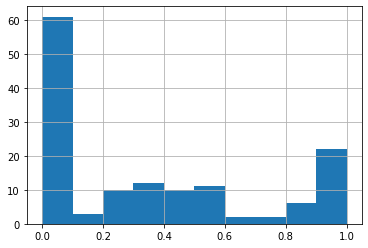

In [49]:
newstats_df['precision'].hist()

<AxesSubplot:>

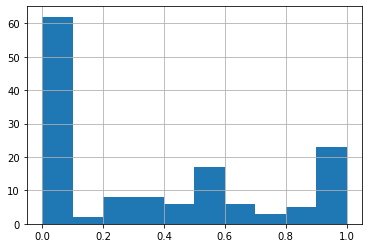

In [46]:
newstats_df['recall'].hist()

<AxesSubplot:xlabel='num_gt_mates', ylabel='precision'>

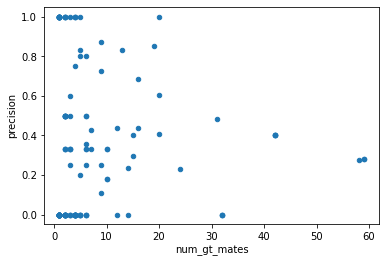

In [51]:
newstats_df.plot.scatter('num_gt_mates', 'precision')

<AxesSubplot:xlabel='num_gt_mates', ylabel='recall'>

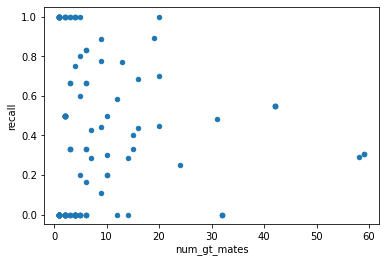

In [52]:
newstats_df.plot.scatter('num_gt_mates', 'recall')

<AxesSubplot:xlabel='precision', ylabel='recall'>

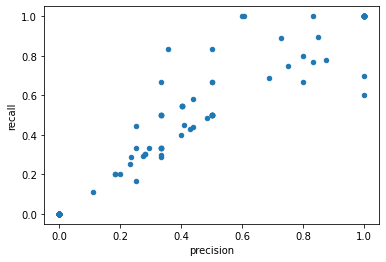

In [54]:
newstats_df.plot.scatter('precision', 'recall')

In [58]:
newstats_df.to_parquet('preliminary_network_stats.parquet')